In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

##Discriminator
###### Used to distinguish/maximise difference between real and generated images. Using sigmoid activation so that output is between 0 (fake generated image) and 1 (real image).

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, img_dim):            ## img_dim = 784 (mnist)
    super().__init__()
    self.discriminator = nn.Sequential(
        nn.Linear(img_dim, 128),
        nn.LeakyReLU(0.01),
        nn.Linear(128, 1),
        nn.Sigmoid(),
    )

  def forward(self, x):
    return self.discriminator(x)

##Generator
######Used to generate images of dimension (img_dim) from random noise of dimension (latent_dim). Used to approximate the probability distribution of the image space. Uses tanh activation so that value is between 1 and -1, because we will normalize all the values (betn 1 and -1) of images of mnist ahead.

In [ ]:
class Generator(nn.Module):
  def __init__(self, img_dim, latent_dim):
    super().__init__()
    self.generator = nn.Sequential(
        nn.Linear(latent_dim, 256),
        nn.LeakyReLU(),
        nn.Linear(256, img_dim),
        nn.Tanh(),
    )

  def forward(self, x):
    return self.generator(x)

In [ ]:
lr = 3e-4
latent_dim = 64
img_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 50

In [ ]:
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4544354.79it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134498.38it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1276198.40it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4288727.77it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
discriminator = Discriminator(img_dim)
generator = Generator(img_dim=img_dim, latent_dim=latent_dim)

fixed_noise = torch.randn((batch_size, latent_dim))

disc_optimizer = optim.Adam(discriminator.parameters(), lr = lr)
gen_optimizer = optim.Adam(generator.parameters(), lr = lr)
criterion = nn.BCELoss()


In [ ]:
### Training Loop
for epoch in range(num_epochs):
  for batch_index, (real_image, real_label) in enumerate(loader):
    real_image = real_image.view(-1, 784)
    batch_size = real_image.shape[0]

    ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
    ### BCE Loss = −wn​[yn​⋅logxn​+(1−yn​)⋅log(1−xn​)], so either maximis the above expression or minimize negative of that


    ### for 1st term log(D(x)): Use(x = real_image) and (y = torch of ones, so that 2nd term vanishes in BCE)
    D_x = discriminator(real_image).view(-1)
    loss_d_real = criterion(D_x, torch.ones_like(D_x))

    ### for 2nd term log(1-D(G(z))): Use (z = some random noise) and (y = torch of zeros so that 1st term vanishes in BCE)
    random_noise_z = torch.randn(batch_size, latent_dim)
    G_z = generator(random_noise_z)
    D_G_z = discriminator(G_z).view(-1)
    loss_d_fake = criterion(D_G_z, torch.zeros_like(D_G_z))

    ###Total Loss(Averaged) + Backpropagation step
    loss_d = (loss_d_real + loss_d_fake)/2
    discriminator.zero_grad()
    ### retained graph = True is very important here - it preserves the value of the random_noise_z (we want to use it again in training generator)
    ### which otherwise would have been freed from memory when optimizer.step is called
    loss_d.backward(retain_graph=True)
    disc_optimizer.step()

    ### Train Generator: min log(1 - D(G(z))) which is same as max log(D(G(z)) which is same as min -log(D(G(z))) (1st term of BCE)
    gen_D_G_z = discriminator(G_z).view(-1)
    loss_g = criterion(gen_D_G_z, torch.ones_like(gen_D_G_z))
    generator.zero_grad()
    loss_g.backward()
    gen_optimizer.step()

    if batch_index == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_index}/{len(loader)} \
                      Loss D: {loss_d:.4f}, loss G: {loss_g:.4f}"
            )

            with torch.no_grad():
                fake = generator(fixed_noise).reshape(-1, 1, 28, 28)
                data = real_image.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1

Epoch [0/50] Batch 0/1875                       Loss D: 0.3041, loss G: 1.9287
Epoch [1/50] Batch 0/1875                       Loss D: 0.4871, loss G: 1.2628
Epoch [2/50] Batch 0/1875                       Loss D: 0.4135, loss G: 1.8537
Epoch [3/50] Batch 0/1875                       Loss D: 0.4800, loss G: 2.3746
Epoch [4/50] Batch 0/1875                       Loss D: 0.6107, loss G: 1.4004
Epoch [5/50] Batch 0/1875                       Loss D: 0.6032, loss G: 1.3277
Epoch [6/50] Batch 0/1875                       Loss D: 0.6165, loss G: 1.3581
Epoch [7/50] Batch 0/1875                       Loss D: 0.5859, loss G: 2.3459
Epoch [8/50] Batch 0/1875                       Loss D: 0.7830, loss G: 0.9420
Epoch [9/50] Batch 0/1875                       Loss D: 0.7017, loss G: 1.3079
Epoch [10/50] Batch 0/1875                       Loss D: 0.6005, loss G: 1.5058
Epoch [11/50] Batch 0/1875                       Loss D: 0.7164, loss G: 1.6953
Epoch [12/50] Batch 0/1875                       L

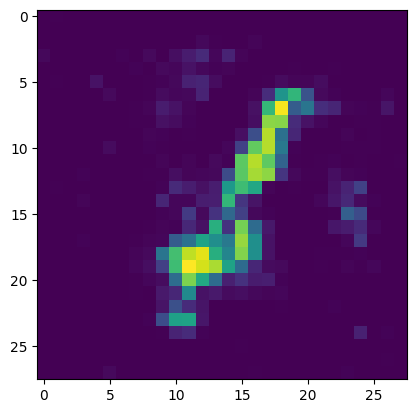

In [ ]:
noise = torch.randn(latent_dim)
gen_img = generator(noise).detach().numpy()

plt.imshow(gen_img.reshape(28, 28))